In [23]:
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

LAMBDA_PEN = 1
L_BOUND = -10
U_BOUND = 10
N_POINTS = 500

num_epochs = 30000

M_POINTS = 5
ALPHA = 2

SELECTION_RATE = 0.05

DISCRETE_POINTS = np.linspace(L_BOUND, U_BOUND, N_POINTS)

In [19]:
def epsilon_Loss(v_x, model_u, upper_bound, discrete_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    total = 0
    h = (2*upper_bound)/(len(discrete_points)-1)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime_x = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        t = torch.abs(torch.square(u_prime_x)) + v_xi*torch.square(u_xi)

        total += t
    return h*total

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         upper_bound, discrete_points):
    """
    
    """
    eps_sum = 0
    pen = 0
    
    h = (2*upper_bound)/(len(discrete_points)-1)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_prime = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        u_xi = model_u(x_i)
        u_xi_square = torch.square(u_xi)

        t = torch.abs(torch.square(u_prime)) + v_xi*u_xi_square
        eps_sum += t
        
        pen+= u_xi_square
        
    epsilon_fn = h*eps_sum
    
    penalty = lambda_pen * torch.square(h*pen-1)
#     print("epsilon_fn value = " + str(epsilon_fn))
#     print("penalty value = " + str(penalty))
    return epsilon_fn + penalty 

In [20]:
epsilon_Loss(potential_fn_class, model, U_BOUND, DISCRETE_POINTS)

tensor([16.2335], grad_fn=<MulBackward0>)

In [21]:
epsilon_Loss_penalty(potential_fn_class, model, LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)

tensor([16.6601], grad_fn=<AddBackward0>)

In [22]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, use_tanh_fn = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = discrete_points[1] - discrete_points[0]
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]
    
    # TRANING MODEL
    def train_network_with_penalty(self, num_epochs, 
                                   v_x, 
                                   optimizer, 
                                   lambda_pen, 
                                   discrete_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            rand_points = np.random.choice(discrete_points, 
                                           size=int(N_POINTS*SELECTION_RATE), 
                                           replace=False)
            loss_pen = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                        U_BOUND, rand_points)
            loss = epsilon_Loss(v_x, self,
                                U_BOUND, rand_points)

            y_loss_pen.append(loss_pen.detach().numpy().item())
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)
        
            if epoch % 100 == 0 or epoch < 30:
                print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
            loss_pen.backward()
            optimizer.step()

        print('Please normalize after training')
        return (x_epochs, y_loss_pen, y_loss)

In [13]:
# For potential function
# ti_list = np.random.normal(loc=0, scale=1.0, size= M_POINTS)
# ci_list = [(U_BOUND/(i * math.pi))**ALPHA for i in range(1, M_POINTS+1)]


def potential_func_iterative(x, t_list, c_list, M_points=M_POINTS, L_endpoint=U_BOUND, c_0=50):
    f_value = 0
    summation = 0
    #Iterative method:

    for i in range(1, M_points+1):
        cos_val = np.cos((i * math.pi * x)/L_endpoint)
        summation += t_list[i-1] * c_list[i-1] * cos_val

    f_value += summation
    f_value += c_0

    return f_value


def potential_func_linalg(x, M_points=20, L_endpoint=U_BOUND, alpha=3, c_0=100):    
    # Linear Algebra method:
    t_i = np.random.normal(0, 1, size=N_points)
    
    iter1 = ((math.pi/(i*L_endpoint))**alpha for i in range(1, M_points+1))
    c_i = np.fromiter(iter1, float)
    a = np.multiply(t_i, c_i)

    iter2 = (i for i in range(1, M_points+1))
    v = np.fromiter(iter2, float)
    s = (L_endpoint*x/math.pi)*v
    cos_s = np.cos(s)
    
    res_vector = np.multiply(a, cos_s)
    return np.sum(res_vector) + c_0

In [24]:
class Potential_Function:
    def __init__(self, c_0,
                 M_points=M_POINTS,
                 L_endpoint=U_BOUND, 
                 alpha=ALPHA):
        self.M_points = M_points
        self.L_endpoint = L_endpoint
        self.alpha = alpha
        self.c_0 = c_0
        
        self.ti_list = np.random.normal(loc=0, scale=1.0, size= self.M_points)
        self.ci_list = [(self.L_endpoint/(i * math.pi))**self.alpha for i in range(1, self.M_points+1)]
        
    def forward(self, x):
        f_value = 0
        summation = 0
        #Iterative method:

        for i in range(1, self.M_points+1):
            cos_val = np.cos((i * math.pi * x)/self.L_endpoint)
            summation += self.ti_list[i-1] * self.ci_list[i-1] * cos_val

        f_value += summation
        f_value += self.c_0

        return f_value
    
potential_fn_class = Potential_Function(c_0=50)

In [25]:
def model_on_interval(nn_model, discrete_points):
    x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in discrete_points]

    model_output = []
    for i in x_vals:
        model_output.append(nn_model(i).detach().numpy().item())
    return model_output

In [ ]:
t_f = Potential_Function(c_0=50)
start = time.time()
r1 = potential_func_iterative(10, t_list=ti_list, c_list=ci_list)
end = time.time()
time1 = end-start
# print(r1)
print(time1)

start = time.time()
r2 = t_f.forward(10)
end = time.time()
time2 = end-start
# print(r2)
print(time2)

In [ ]:
y_p = [potential_func_iterative(i, t_list, ci_list) for i in DISCRETE_POINTS]
plt.plot(DISCRETE_POINTS, y_p)

In [ ]:
min_val = 0
for i in range(1000):
    t_list = np.random.normal(loc=0, scale=1.0, size= M_POINTS)
    ci_list = [(U_BOUND/(i * math.pi))**ALPHA for i in range(1, M_POINTS+1)]
    y_p = [potential_func_iterative(i, t_list, ci_list) for i in DISCRETE_POINTS]
    if min(y_p) <= min_val:
        min_val=min(y_p)
min_val

In [168]:
# start = time.time()
# res1 = x_square(10)
# end = time.time()
# time1 = end-start
# print(time1)

# start = time.time()
# res2 = potential_func_iterative(10)
# end = time.time()
# time2 = end-start
# print(time2)

In [17]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None, log_scale=False):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    if log_scale==True:
        plt.yscale('log')
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [26]:
learningRate = 0.0001

#INIT MODEL
model = Nonlinear(20)
model_2 = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()
    model_2.cuda()

# INIT OPTIMIZER CLASS
# SGD:
sgd_optimizer = torch.optim.SGD(model.parameters(), 
                                lr=learningRate, 
                                momentum=0.9)

# Adam:
# adam_optimizer = torch.optim.Adam(model.parameters(), 
#                                     lr=learningRate, 
#                                     betas=(0.9, 0.999), 
#                                     eps=1e-08, 
#                                     weight_decay=0, 
#                                     amsgrad=False)

# adam_optimizer_2 = torch.optim.Adam(model_2.parameters(), 
#                                     lr=learningRate, 
#                                     betas=(0.9, 0.999), 
#                                     eps=1e-08, 
#                                     weight_decay=0, 
#                                     amsgrad=False)

In [27]:
### TRAIN MODEL HERE ###
start = time.time()
model_res = model.train_network_with_penalty(num_epochs, 
                                             potential_fn_class, 
                                             sgd_optimizer, 
                                             LAMBDA_PEN, 
                                             DISCRETE_POINTS)
end = time.time()
time1 = end-start
print("Using potential function defined as class takes " + str(time1))

epoch 0, loss with penalty 9.450722694396973
epoch 1, loss with penalty 8.407111167907715
epoch 2, loss with penalty 4.113874912261963
epoch 3, loss with penalty 3.83154034614563
epoch 4, loss with penalty 9.487649917602539
epoch 5, loss with penalty 4.425574779510498
epoch 6, loss with penalty 5.4630351066589355
epoch 7, loss with penalty 2.0056371688842773
epoch 8, loss with penalty 5.5058135986328125
epoch 9, loss with penalty 4.162752151489258
epoch 10, loss with penalty 3.6876330375671387
epoch 11, loss with penalty 3.065707206726074
epoch 12, loss with penalty 1.4469068050384521
epoch 13, loss with penalty 3.253659725189209
epoch 14, loss with penalty 2.456467628479004
epoch 15, loss with penalty 2.3198556900024414
epoch 16, loss with penalty 1.9249862432479858
epoch 17, loss with penalty 1.4462140798568726
epoch 18, loss with penalty 1.429757833480835
epoch 19, loss with penalty 1.5346626043319702
epoch 20, loss with penalty 1.5402237176895142
epoch 21, loss with penalty 1.33795

In [37]:
model.normalize_model(DISCRETE_POINTS)

Before normalization: 
tensor([[-0.0243, -0.0453,  0.1663,  0.0300, -0.0896, -0.0517, -0.0265,  0.0522,
         -0.0129, -0.1692,  0.0117, -0.1915, -0.0364,  0.0354, -0.0472,  0.1472,
          0.0817,  0.0149,  0.0188, -0.0248]])
tensor([0.0703])
After normalization: 
tensor([[ -43.0240,  -80.3909,  294.8353,   53.2674, -158.8362,  -91.5976,
          -46.9601,   92.5205,  -22.9602, -300.1158,   20.6648, -339.5419,
          -64.6008,   62.8547,  -83.7061,  260.9976,  144.8682,   26.4314,
           33.3771,  -43.9639]])
tensor([124.5793])
c value = tensor([1773.2131], grad_fn=<MulBackward0>)


<Figure size 432x288 with 0 Axes>

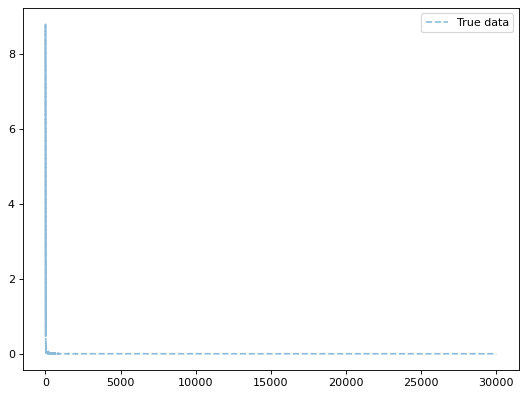

In [28]:
plot_figure(model_res[0], (model_res[2]))

<Figure size 432x288 with 0 Axes>

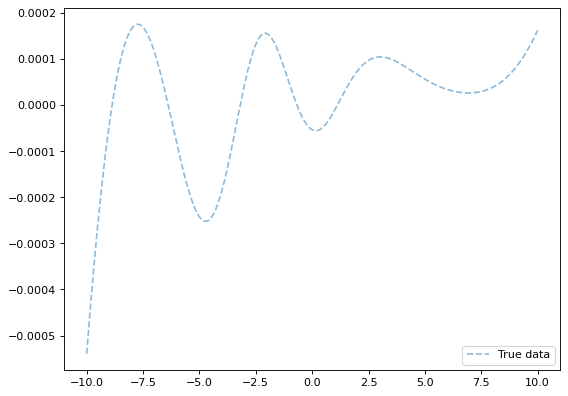

In [29]:
x_values = np.linspace(L_BOUND, U_BOUND, N_POINTS)
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in np.linspace(L_BOUND, U_BOUND, N_POINTS)]

model_output = model_on_interval(model, DISCRETE_POINTS)

plot_figure(x_values, model_output)
# plot_figure(x_values, model_output)

## The Finite Difference Method ##

In [31]:
def fd_method_2(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)
    H = np.zeros((N_points-2,N_points-2))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points-2,N_points-2))
    
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
                
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])
                
    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [32]:
def finite_diff_method(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)

    H = np.zeros((N_points,N_points))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points,N_points))

    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])

    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [33]:
def plot_finite_diff_sol(eig_val, ground_state, discrete_points, nn_model):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * ground_state)

        plt.plot(discrete_points,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    model_output = model_on_interval(nn_model, DISCRETE_POINTS)
    plt.plot(discrete_points, model_output)
    plt.legend()
    plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

In [34]:
fd_res = finite_diff_method(L_BOUND, U_BOUND, N_POINTS, potential_fn_class)
fd_res2 = fd_method_2(L_BOUND, U_BOUND, N_POINTS, potential_fn_class)

In [38]:
loss_val = epsilon_Loss(potential_fn_class, model, U_BOUND, DISCRETE_POINTS)
print("The FD method eigenvalue: " + str(fd_res[0][0]))
print("The NN method loss value: " + str(loss_val.item()))

The FD method eigenvalue: 35.80473777344683
The NN method loss value: 55.55067443847656


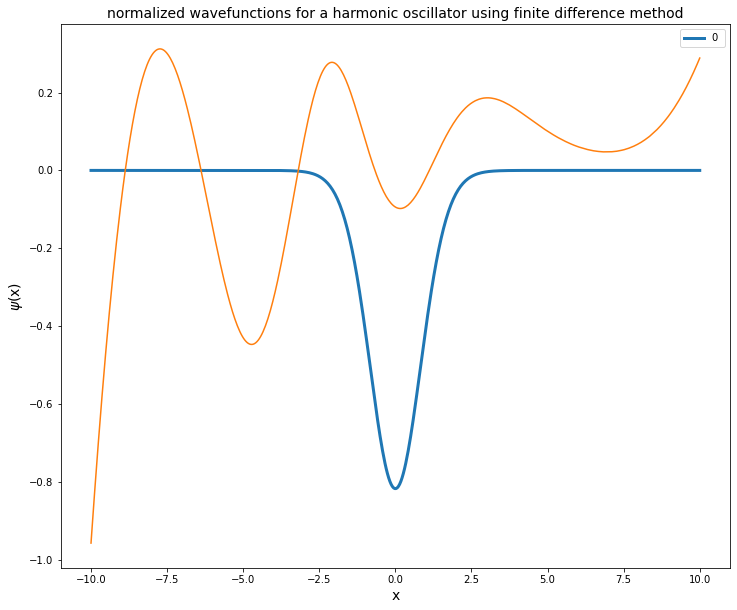

In [39]:
plot_finite_diff_sol(fd_res[0], fd_res[1], DISCRETE_POINTS, model)